# Introduction to CNN Keras

# 1.Introduction

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook',palette='deep')

# 2.Data preparation

# 2.1Load data

In [57]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [58]:
train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [59]:
test.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [60]:
test.isnull().any().head()

pixel0    False
pixel1    False
pixel2    False
pixel3    False
pixel4    False
dtype: bool

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

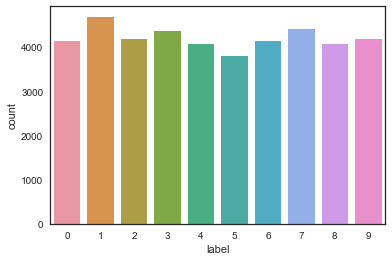

In [61]:
Y_train = train['label']
X_train = train.drop(labels=['label'],axis=1)

#trainを削除
del train
#棒グラフ表示
g = sns.countplot(Y_train)
#labelの
Y_train.value_counts()

# 2.2 Check for null and missing values

In [62]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [63]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# 2.3 Nomalization

In [64]:
X_train = X_train / 255.0
test = test / 255.0

In [72]:
X_train.values.reshape(-1)

array([0., 0., 0., ..., 0., 0., 0.])

# 2.4 Reshape

In [73]:
# Reshape image in 3 dimensions (height=28px, width = 28px, channel = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# 2.5 Label encoding

In [77]:
type(Y_train)

pandas.core.series.Series

In [78]:
# Encoding labels to one hot vectors (ex: 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
Y_train = to_categorical(Y_train, num_classes = 10)

# 2.6 Split training and valdiation set

In [79]:
random_seed = 2

In [80]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

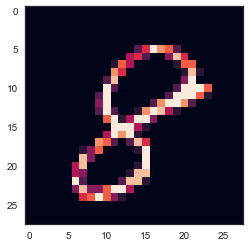

In [81]:
g = plt.imshow(X_train[0][:, :, 0])

In [82]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# 3.CNN

# 3.1Define the model

In [15]:
#Set the CNN model
#my CNN architechture is In -> [[Cov2D -> relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu', input_shape = (28, 28, 1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

# 3.2 Set the optimizer and annealer

In [16]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [18]:
# monitor: 監視する値．
# factor: 学習率を減らす割合．new_lr = lr * factor
# patience: 何エポック改善が見られなかったら学習率の削減を行うか．
# verbose: 整数．0: 何も表示しない．1: 学習率削減時メッセージを表示．
# min_lr:学習率の下限
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [19]:
epochs = 1
batch_size = 86

# 3.3 Data augumentation

Data Augmentation
・grayscales
・horizontal/vertical flips
・random crops
・color jitters
・translations
・rotations

In [20]:
# Without data augmentation I obtained an accuracy of 0.98114
# history = model.fit(X_train, Y_train, batch_size, = batch_size, epochs = epochs,validation_data = (X_val, Y_val), verbose = 2)

In [21]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)

datagen.fit(X_train)

In [22]:
#Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs = epochs, validation_data=(X_val, Y_val),
                             verbose = 2, steps_per_epoch=X_train.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/1
 - 140s - loss: 0.4139 - acc: 0.8686 - val_loss: 0.0839 - val_acc: 0.9736


# 4.Evaluate the model

# 4.1 Training and validation curves

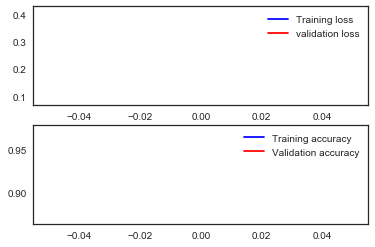

In [23]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'],color='r',label='Validation accuracy')
legend = ax[1].legend(loc='best',shadow=True)

In [24]:
history.history['loss']

[0.41387417907391705]

# 4.2 Confusion matrix

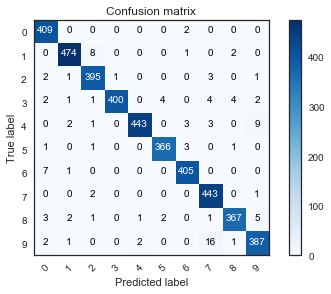

In [25]:
# look at confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert prediction classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observation to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

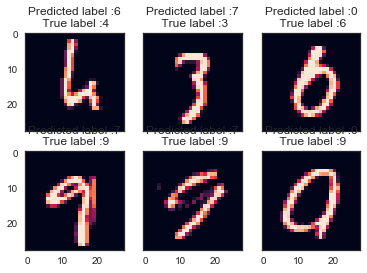

In [28]:
# Display some error results
#Errors are difference between predicted labels and true labels

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title('Predicted label :{}\n True label :{}'.format(pred_errors[error],obs_errors[error]))
            n += 1
#Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

#Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

#Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [29]:
# predict results
results = model.predict(test)

#select the indix with the maximum probability
results = np.argmax(results,axis=1)

results = pd.Series(results,name='Label')

In [31]:
submission = pd.concat([pd.Series(range(1, 28001), name = 'ImageId'), results], axis=1)
submission.to_csv('cnn_mnist_datagen.csv', index=False)